In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

from PopSynthesis.Methods.connect_HH_PP.paras_dir import processed_data, output_dir, data_dir

In [3]:
font = {'weight' : 'bold',
        'size'   : 18}
plt.rc('font', **font)

geo_lev = "POA"

In [4]:
syn_hh_ipu = pd.read_csv(os.path.join(output_dir, "testland","syn_hh_ipu.csv"))
syn_pp_ipu = pd.read_csv(os.path.join(output_dir, "testland","syn_pp_ipu.csv"))

In [5]:
syn_hh_ipu = syn_hh_ipu.drop(columns=["serialno", "cat_id", "sample_geog"])
syn_hh_ipu = syn_hh_ipu.rename(columns={"geog": "POA"})
syn_hh_ipu["hhid"] = syn_hh_ipu.index
syn_pp_ipu = syn_pp_ipu.drop(columns=["serialno", "cat_id", "sample_geog"])
syn_pp_ipu = syn_pp_ipu.rename(columns={"household_id": "hhid", "geog": "POA"})

In [6]:
syn_hh_adjust= pd.read_csv(os.path.join(output_dir, "testland","syn_hh_final_afteradjust.csv"))
syn_pp_adjust = pd.read_csv(os.path.join(output_dir, "testland","syn_pp_final_afteradjust.csv"))

In [7]:
dict_hhid = dict(zip(syn_hh_adjust["hhid"], syn_hh_adjust[geo_lev]))
syn_pp_adjust[geo_lev] = syn_pp_adjust.apply(lambda r: dict_hhid[int(r["hhid"])],axis=1)
syn_pp_adjust

,age,sex,persinc,nolicence,anywork,hhid,relationship,POA
0,0-9,F,Zero Income,No Licence,N,881439,Child,3012
1,0-9,F,Zero Income,No Licence,N,882725,Child,3013
2,0-9,M,Zero Income,No Licence,N,882812,Child,3015
3,0-9,F,Zero Income,No Licence,N,884601,Child,3020
4,0-9,M,Zero Income,No Licence,N,904723,Child,3030
...,...,...,...,...,...,...,...,...
6251973,30-39,M,$1000-1249 p.w.,Some Licence,Y,2482539,Main,3704
6251974,50-59,F,$1-199 p.w.,Some Licence,Y,2756291,Main,3704
6251975,50-59,M,$1000-1249 p.w.,Some Licence,Y,2756292,Main,3704
6251976,90-99,M,Zero Income,Some Licence,N,2756293,Main,3704


In [8]:
ls_atts_pp = [x for x in syn_pp_adjust.columns if x not in ["relationship", "POA", "hhid", "age", "persinc"]]
atts_labels = {att: list(syn_pp_adjust[att].unique()) for att in ls_atts_pp}
atts_labels
# But this is not sorted
atts_labels["age"] = [
    '0-9', 
    '10-19', 
    '20-29', 
    '30-39', 
    '40-49', 
    '50-59', 
    '60-69',
    '70-79',
    '70-79',
    '80-89',
    '90-99',
    "100+"
]

atts_labels ["persinc"] = [
    "Missing/Refused",
    "Negative Income",
    "Zero Income",
    '$1-199 p.w.',
    '$200-299 p.w.',
    '$300-399 p.w.',
    '$400-599 p.w.',
    '$600-799 p.w.',
    '$800-999 p.w.',
    '$1000-1249 p.w.',
    '$1250-1499 p.w.',
    '$1500-1999 p.w.',
    '$2000+ p.w.'
]

In [11]:
def plot_bar_syn_rela(rela, att):
    df_ipu = syn_pp_ipu[syn_pp_ipu["relationship"] == rela]
    df_adjust = syn_pp_adjust[syn_pp_adjust["relationship"] == rela]
    n_ipu = len(df_ipu) 
    counts_ipu = df_ipu[att].value_counts()
    n_adjust = len(df_adjust) 
    counts_adjust = df_adjust[att].value_counts()

    data_ipu = []
    data_adjust = []
    data_sample = []
    if rela != "Main":
        df_rela_sample = pd.read_csv(os.path.join(processed_data, f"connect_main_{rela}.csv"))
        sub_df_sample = df_rela_sample.groupby(f"{att}_{rela}")["_weight"].sum() 
    else:
        df_rela_sample = pd.read_csv(os.path.join(processed_data, f"connect_hh_main.csv"))
        sub_df_sample = df_rela_sample.groupby(att)["_weight"].sum()
    n_sample = df_rela_sample["_weight"].sum()
    sub_df_sample = sub_df_sample / n_sample
    for state in atts_labels[att]:
        if state in counts_ipu.index:
            data_ipu.append((counts_ipu.at[state]/n_ipu)*100) 
        else:
            data_ipu.append(0) 

        if state in counts_adjust.index:
            data_adjust.append((counts_adjust.at[state]/n_adjust)*100) 
        else:
            data_adjust.append(0) 

        if state in sub_df_sample.index:
            data_sample.append((sub_df_sample[state])*100)
        else:
            data_sample.append(0)
    X = atts_labels[att]
    X_axis = np.arange(len(X))
    fig = plt.figure(figsize = (10, 5))
    # creating the bar plot
    plt.bar(X_axis - 0.3, data_ipu, 0.2, label = 'IPU') 
    plt.bar(X_axis - 0.1, data_adjust, 0.2, label = 'Adjustment algo') 
    plt.bar(X_axis + 0.2, data_sample, 0.4, label = 'VISTA') 
    plt.xlabel(f"{att} groups")
    plt.ylabel(f"Percentage in the {rela} population")
    plt.title(f"Total number people for each {att} groups for {rela}")
    plt.xticks(X_axis, X, rotation=45)
    plt.legend() 
    # plt.show()
    plt.savefig(f"./output/imgs/samples/{rela}_{att}_samples_compa")
    return {
        "vista": data_sample,
        "ipu": data_ipu,
        "adjust": data_adjust,
        "states": list(atts_labels[att])
    }

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_19004\2501234792.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (10, 5))


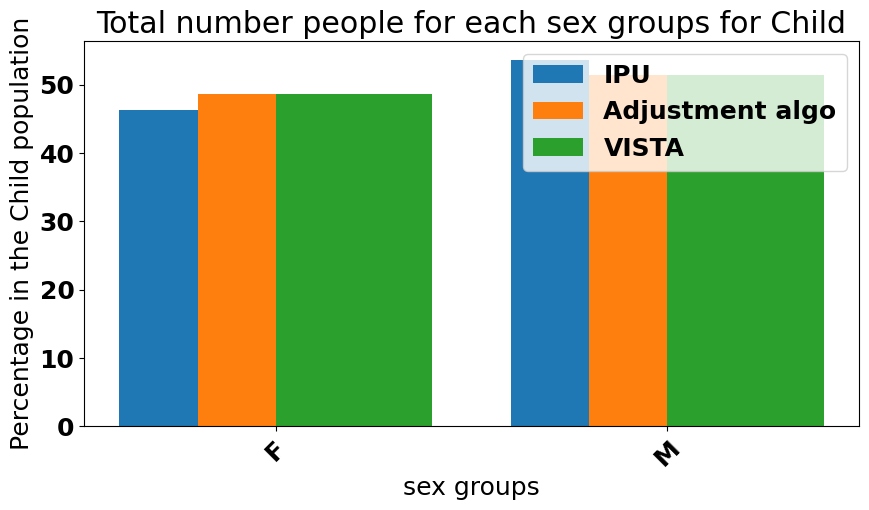

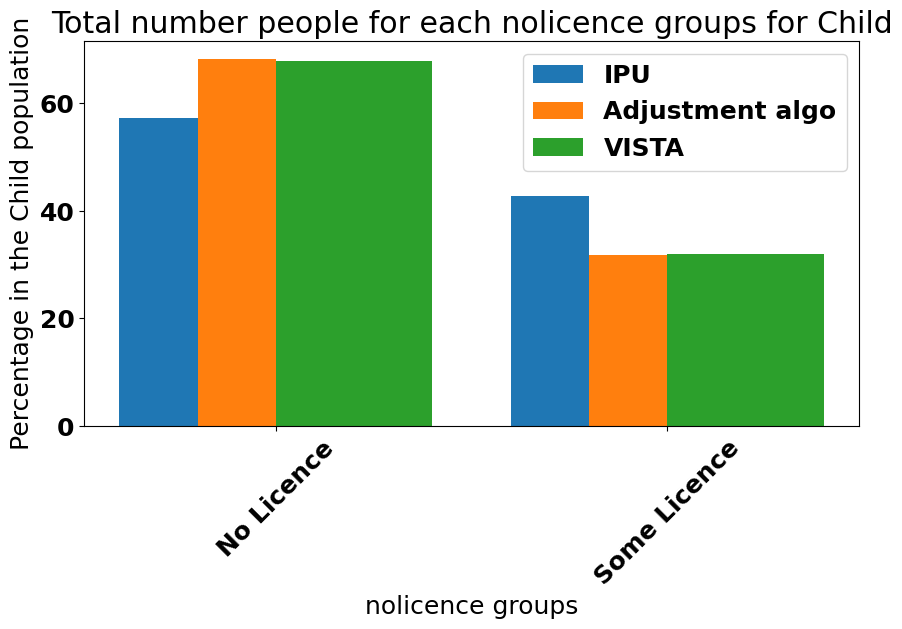

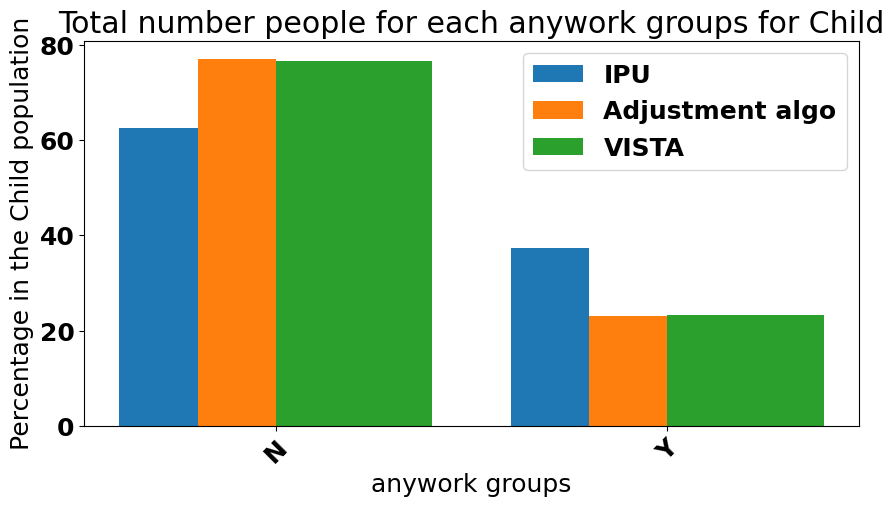

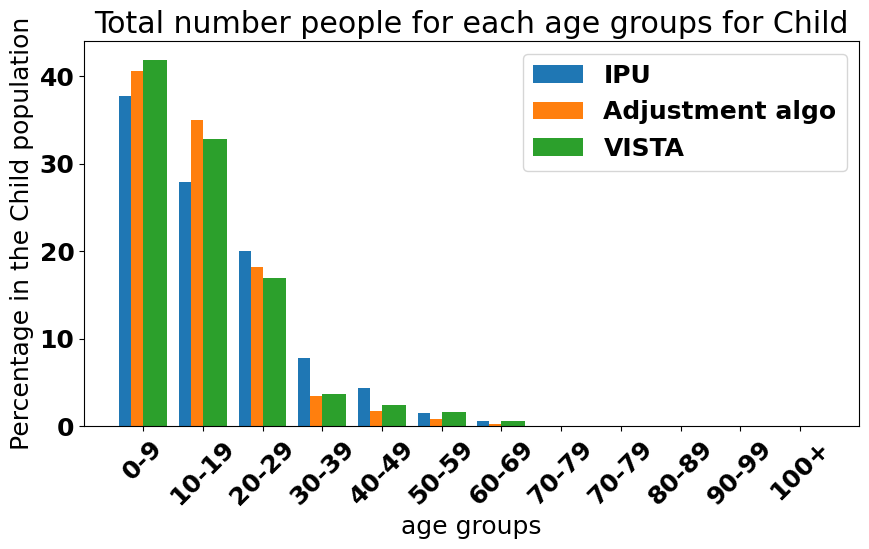

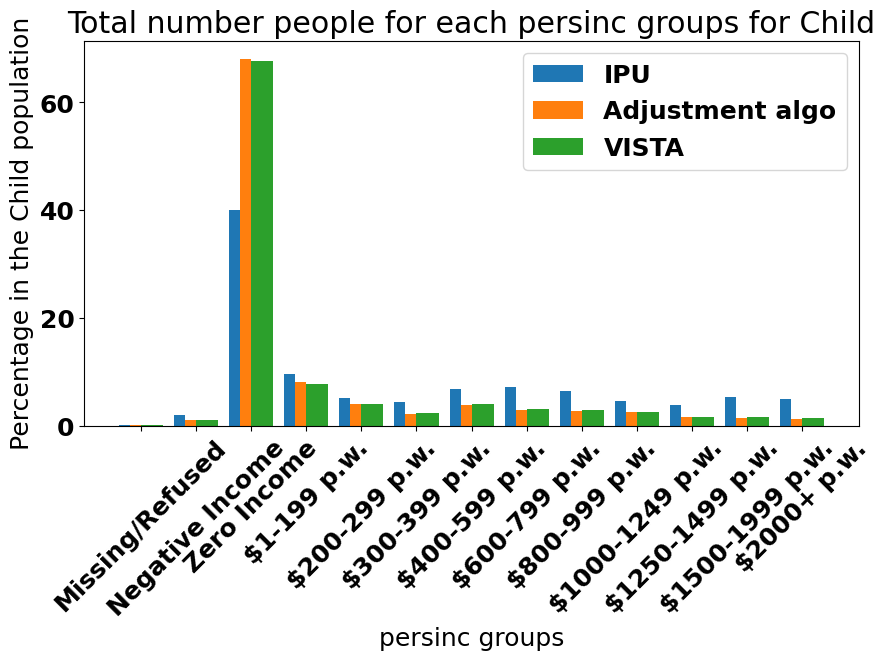

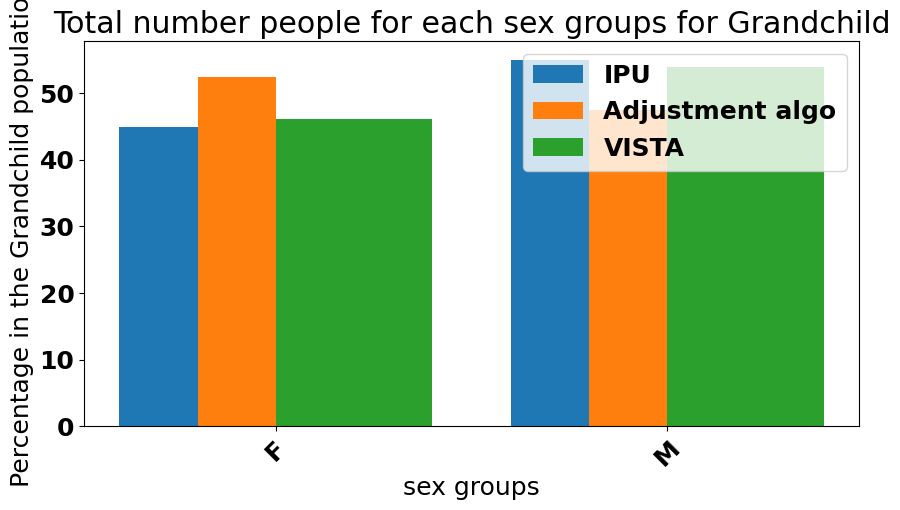

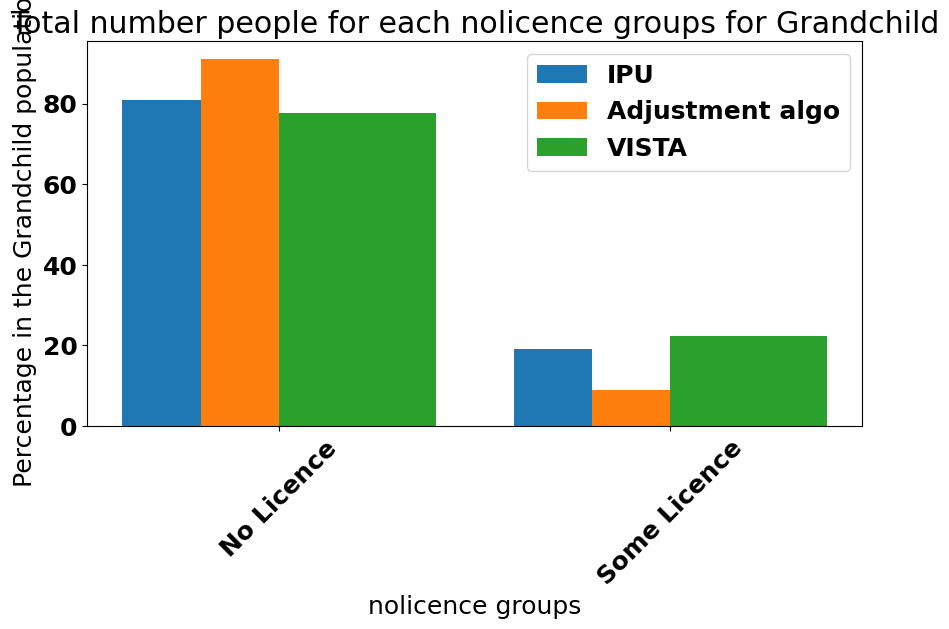

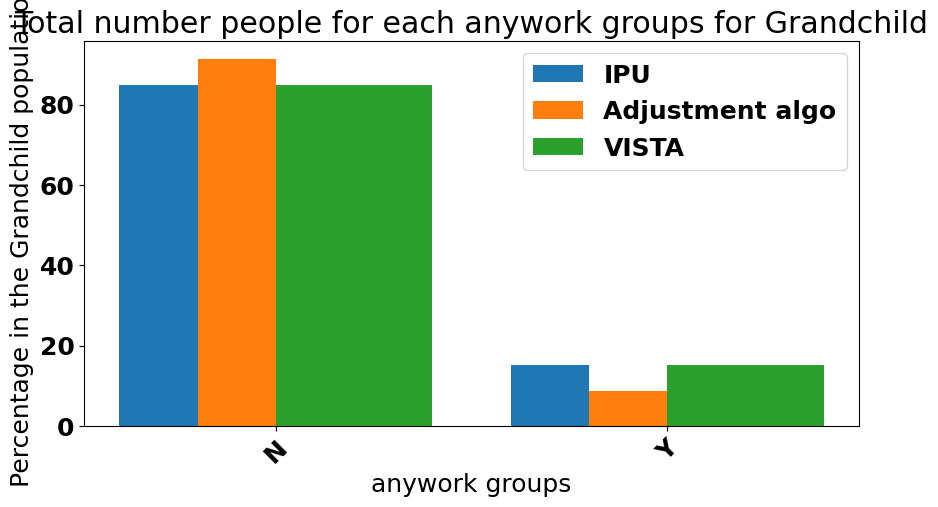

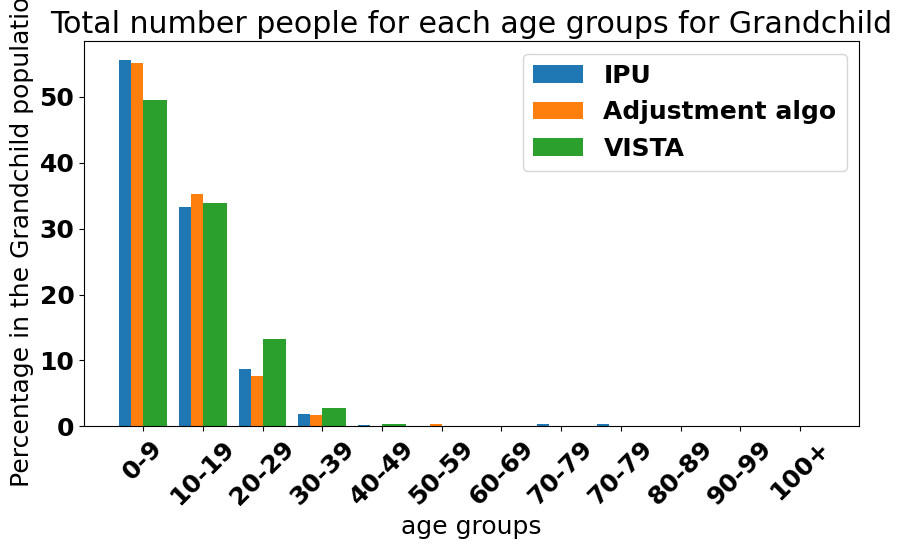

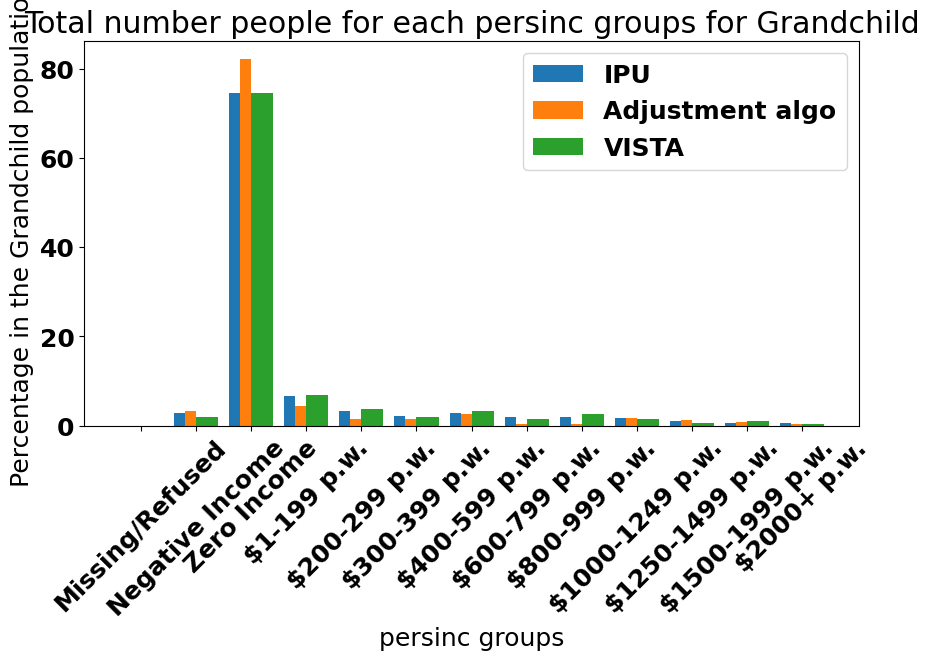

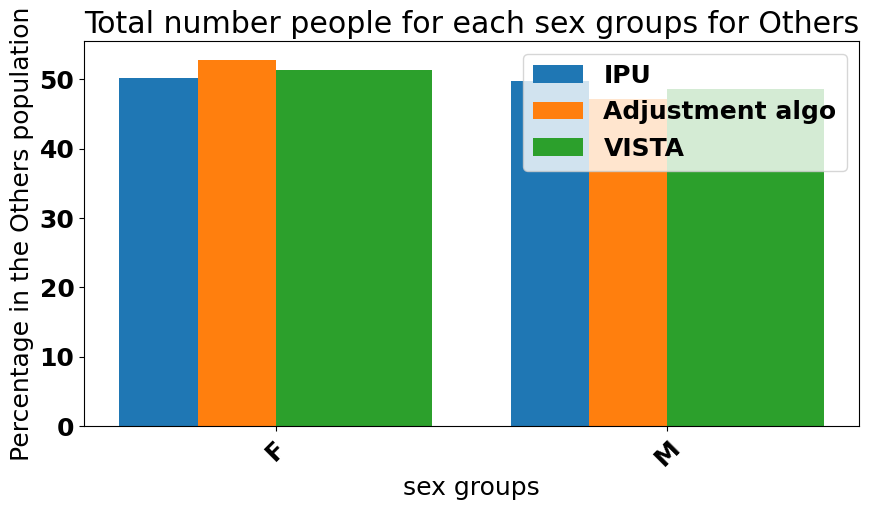

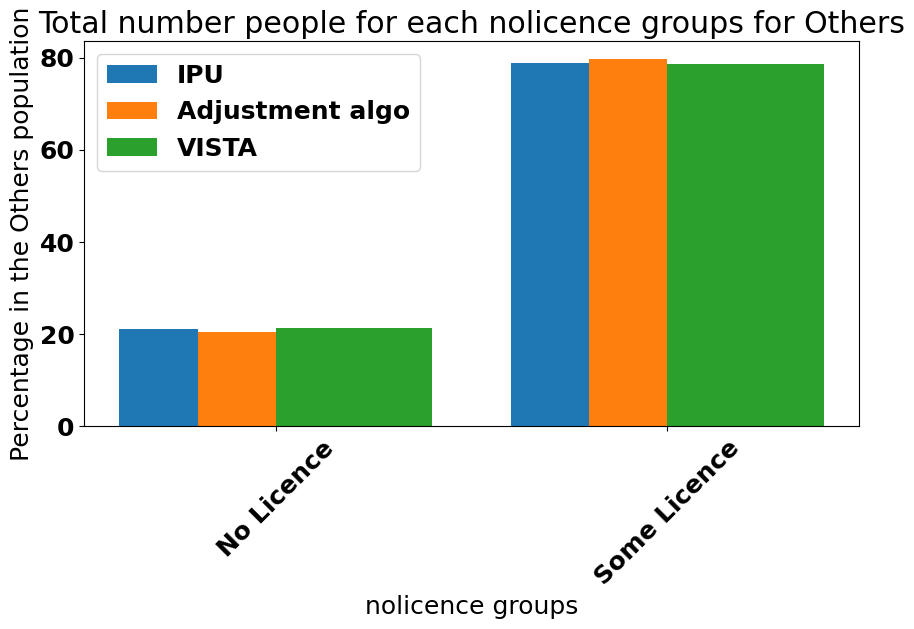

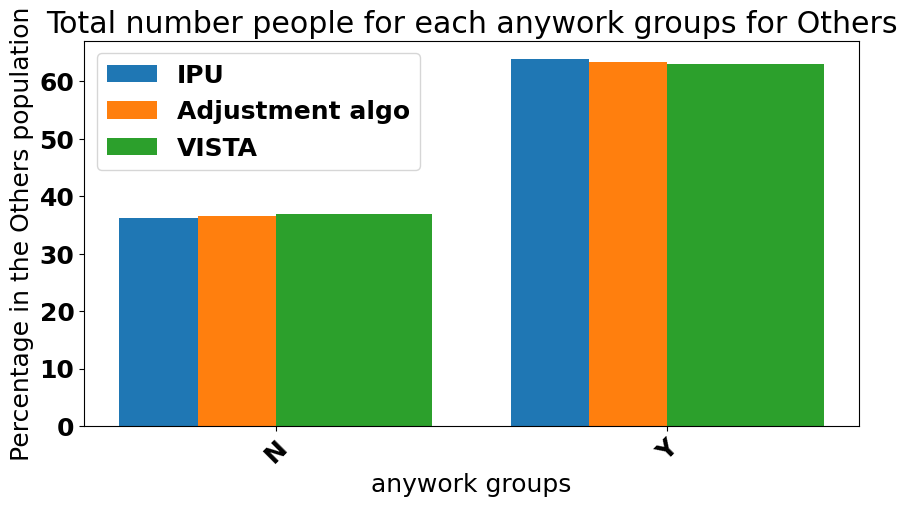

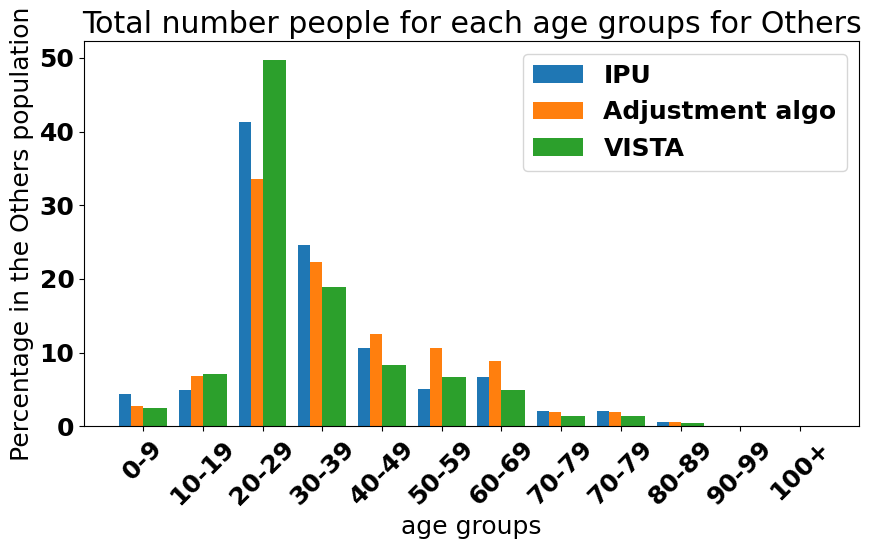

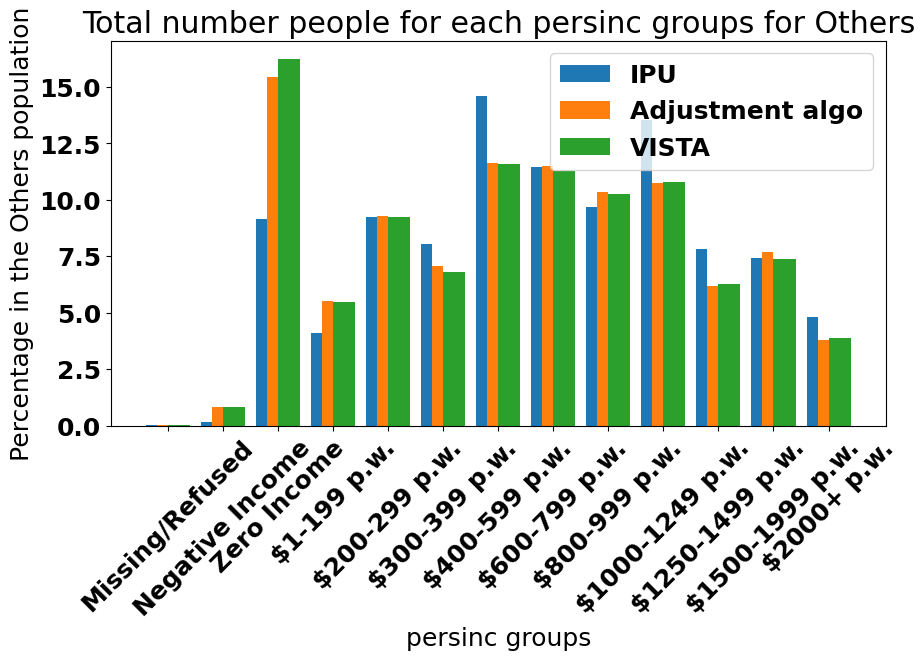

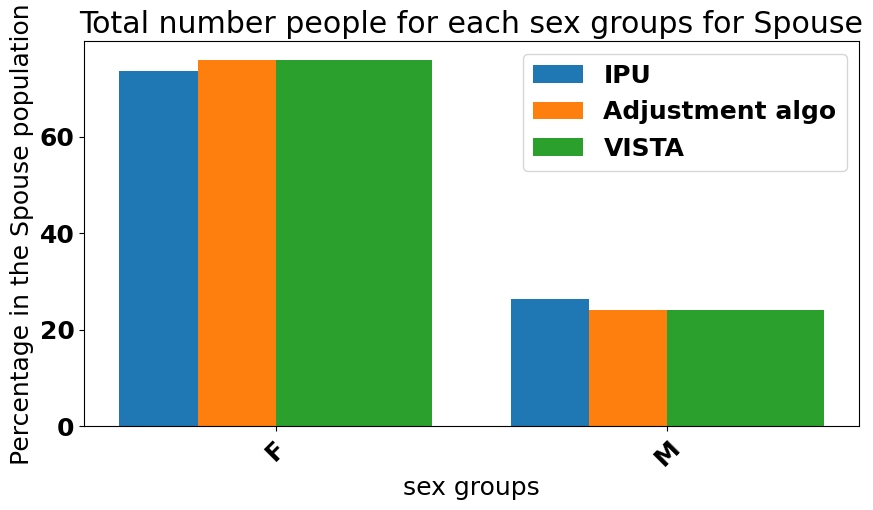

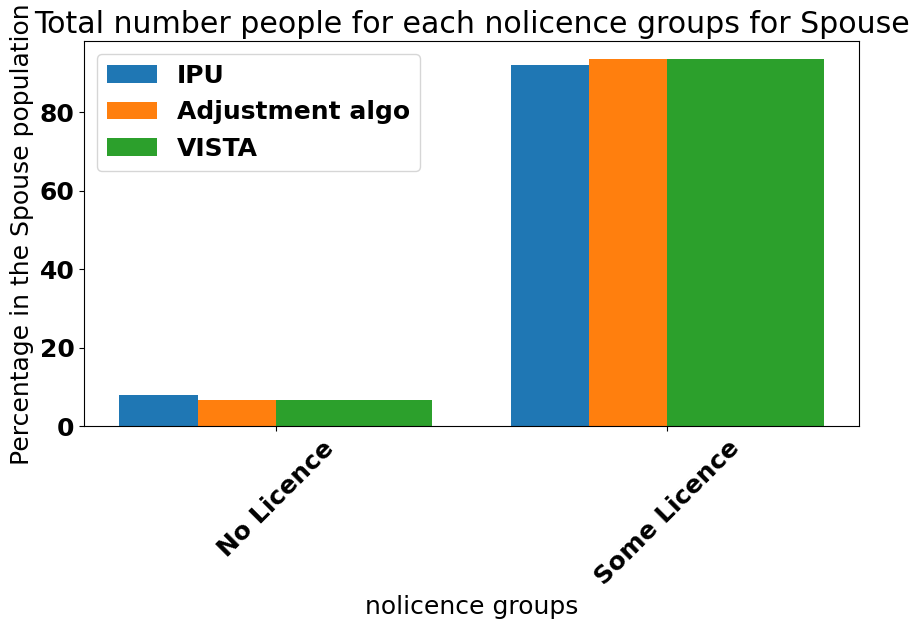

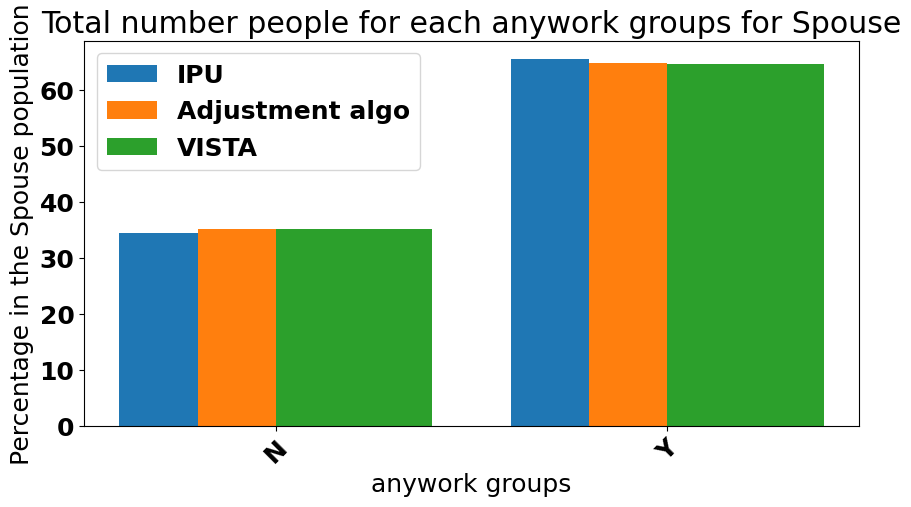

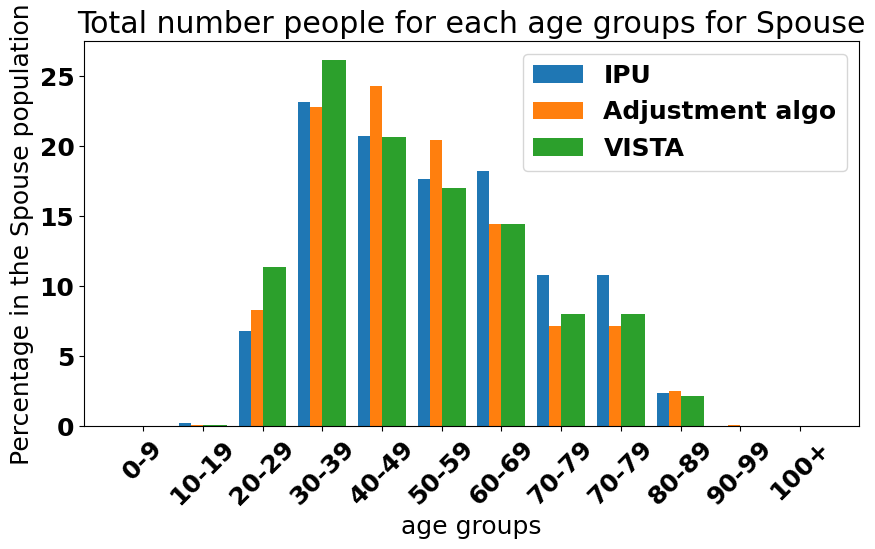

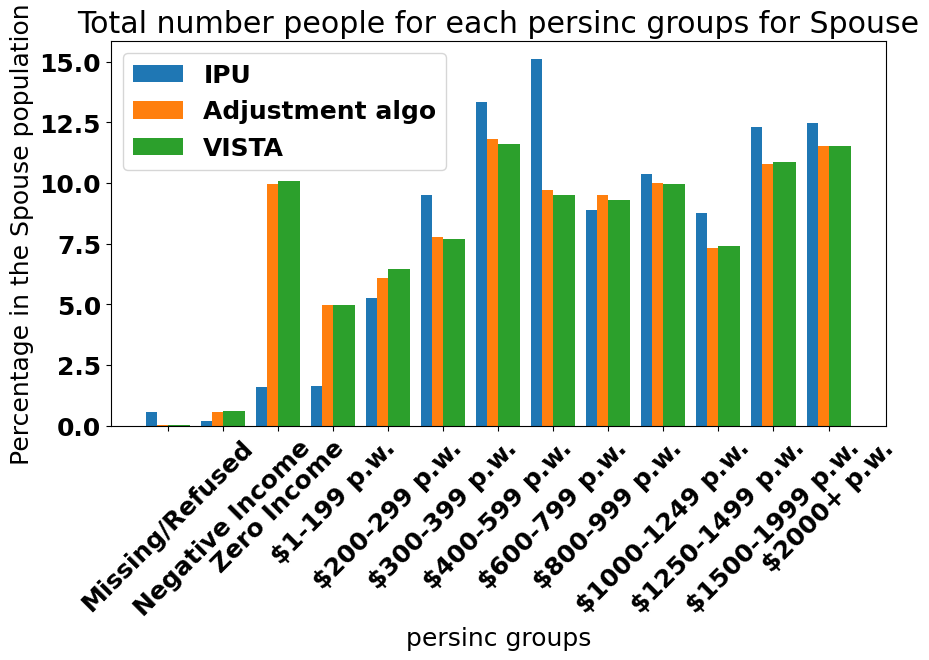

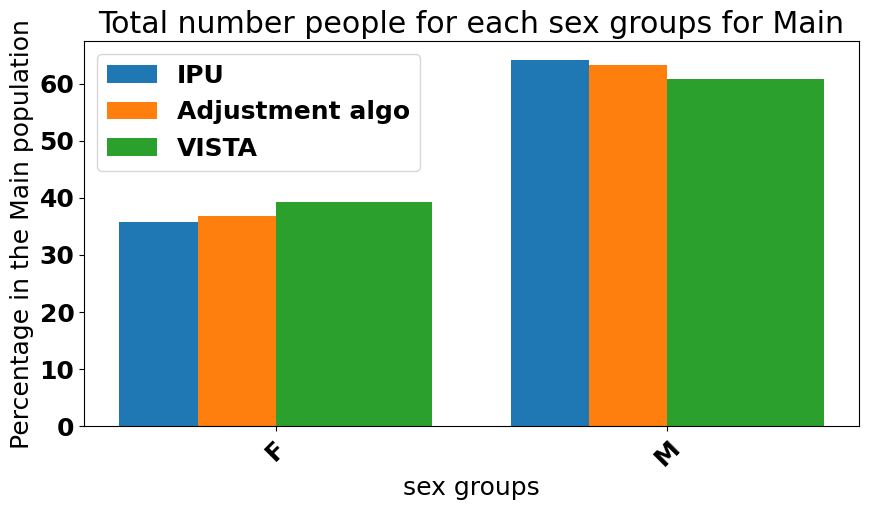

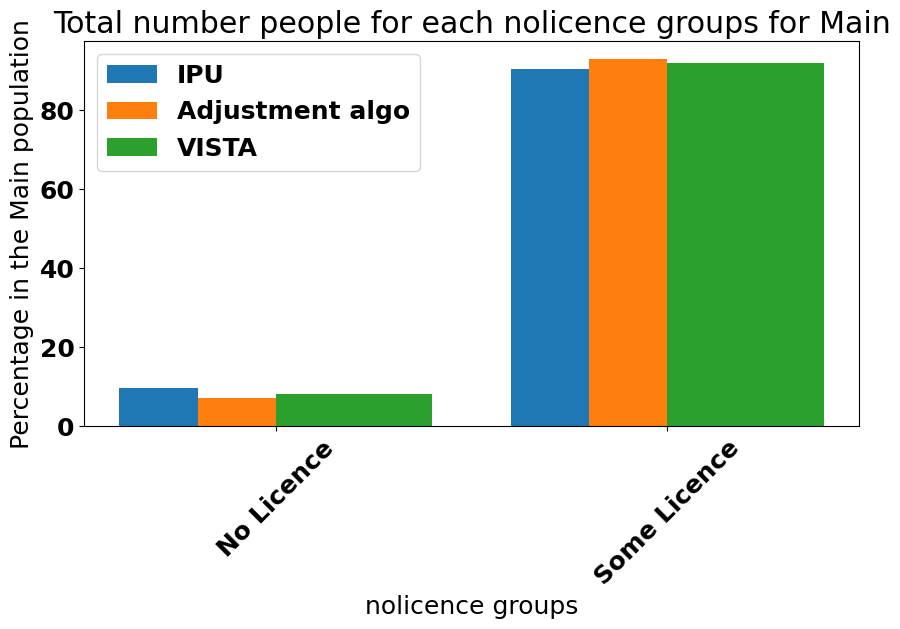

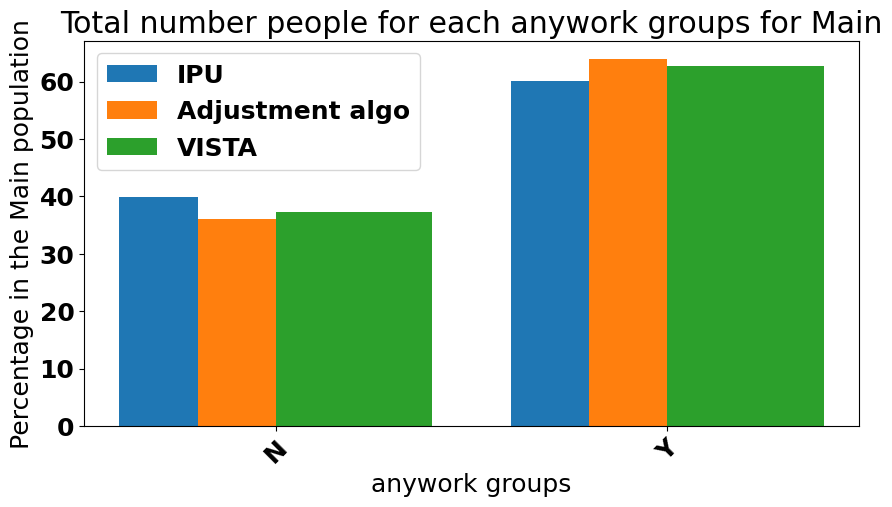

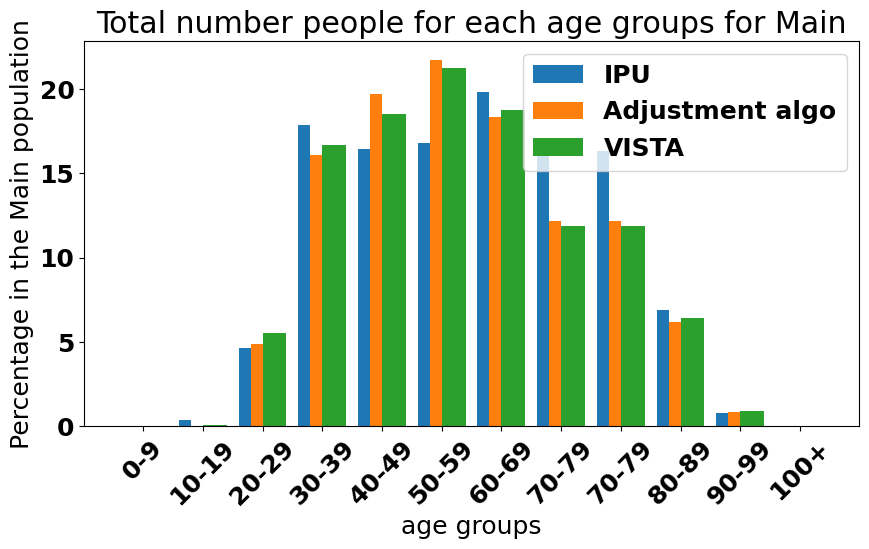

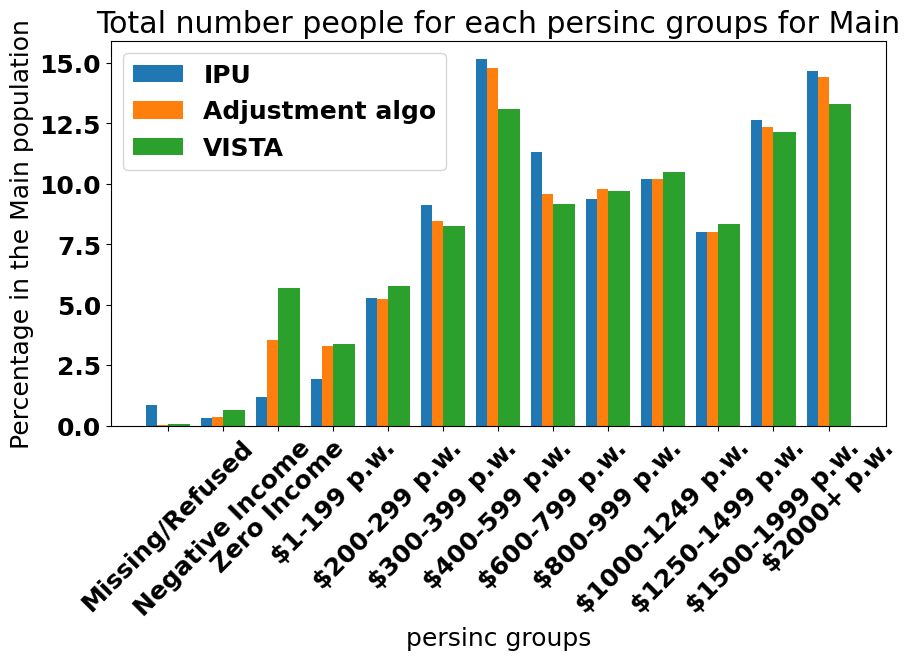

In [12]:
ls_rela = syn_pp_adjust["relationship"].unique()
hold_dict = {}
for rela in ls_rela:
    for att in atts_labels:
        re_dict = plot_bar_syn_rela(att=att, rela=rela)
        hold_dict[f"{rela}_{att}"] = re_dict

In [10]:
# now I need a table lol of the diff, for each rela (compared with IPU), for each atts as well

# table of decreased err as well for each adjustments, JensonShannon based on KL divergence (related to cross entropy)
# Maybe think about chi-square

In [10]:
from scipy.spatial.distance import jensenshannon

<function scipy.spatial.distance.jensenshannon(p, q, base=None, *, axis=0, keepdims=False)>

In [41]:
d_df = []
ls_names = []
for key, d in hold_dict.items():
    score_ipu = jensenshannon(d["vista"], d["ipu"], base=2)
    score_adjust = jensenshannon(d["vista"], d["adjust"], base=2)
    d_df.append([score_ipu, score_adjust])
    ls_names.append(key)

cols_names = ["IPU_score", "Adjust_score"]
df_all_scores = pd.DataFrame(d_df, index=ls_names, columns=cols_names)
df_all_scores    

,IPU_score,Adjust_score
Child_sex,0.019289,0.000376
Child_nolicence,0.094191,0.002193
Child_anywork,0.130198,0.003318
Child_age,0.103881,0.052093
Child_persinc,0.252863,0.012917
Grandchild_sex,0.009360,0.054468
Grandchild_nolicence,0.032453,0.156446
Grandchild_anywork,0.000243,0.085159
Grandchild_age,0.089470,0.105974
Grandchild_persinc,0.055579,0.145709


In [42]:
d_rela = []
for rela in ls_rela:
    sub_df_avg = df_all_scores[df_all_scores.index.str.contains(rela)].mean()
    d_rela.append(list(sub_df_avg))

df_by_rela = pd.DataFrame(d_rela, columns=cols_names, index=ls_rela)
df_by_rela

,IPU_score,Adjust_score
Child,0.120084,0.014179
Grandchild,0.037421,0.109551
Others,0.049322,0.037990
Spouse,0.069922,0.015879
Main,0.059750,0.024668


In [43]:
d_atts = []
for att in atts_labels:
    sub_df_avg = df_all_scores[df_all_scores.index.str.contains(att)].mean()
    d_atts.append(list(sub_df_avg))

df_by_atts = pd.DataFrame(d_atts, columns=cols_names, index=atts_labels)
df_by_atts

,IPU_score,Adjust_score
sex,0.018389,0.017907
nolicence,0.034813,0.037014
anywork,0.033509,0.020543
age,0.097019,0.080439
persinc,0.152769,0.046364


In [44]:
def quick_f(df): 
    df["Adjust_to_IPU"] = (df["Adjust_score"] - df["IPU_score"])/df["IPU_score"]
    return df

df_all_scores = quick_f(df_all_scores)
df_by_rela = quick_f(df_by_rela)
df_by_atts = quick_f(df_by_atts)

In [46]:
df_all_scores.to_csv("./output/tables/samples_all.csv")
df_by_rela.to_csv("./output/tables/samples_rela.csv")
df_by_atts.to_csv("./output/tables/samples_atts.csv")